In [28]:
%pylab

import pandas as pd
import pickle
from scipy.linalg import norm
import cv2 as cv
import os
import importlib
from sklearn.preprocessing import normalize
from skimage.io import imsave, imread
import os
import glob
import argparse
import time
import pickle
import platform
import shutil
import json

import numpy as np
import pandas as pd
import cv2 as cv
from skimage.io import imsave
from scipy.stats import entropy
from scipy.linalg import norm
import h5py

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, ZeroPadding2D, LeakyReLU, Flatten, Concatenate
from keras.layers.merge import add
from keras.utils import multi_gpu_model
from keras.utils.data_utils import Sequence
import keras.backend as K
from keras import optimizers
from keras.layers import Conv2D, Conv2DTranspose, Reshape
import keras

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['add', 'sample', 'imread', 'imsave', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
cd D:\\topcoder\\face_recog\\src\\space

D:\topcoder\face_recog\src\space


In [3]:
import sys
sys.path.append('D:\\topcoder\\face_recog\\src')

In [63]:
with open('ref_facial_id_db.pickle', 'rb') as f:
    facial_ids = pickle.load(f)

In [64]:
diff_norms = []
for subject_id in facial_ids:
    diff_norms.append(norm(facial_ids[1] - facial_ids[subject_id]))
diff_norms = np.asarray(diff_norms)[1:]

In [65]:
diff_norms.min(), diff_norms.max(), diff_norms.mean()

(0.23180201649665833, 1.1048119068145752, 0.5986249867136831)

(array([ 2.,  1.,  0.,  1.,  0.,  3.,  2.,  5.,  6.,  9.,  9., 10., 20.,
        11., 12., 13., 10.,  9., 10., 16., 23., 14., 17., 22., 12.,  9.,
        15., 25., 13., 18., 21., 19., 20., 16., 16., 19., 27., 19., 23.,
        22., 23., 26., 20., 19., 20., 18., 22., 23., 20., 12., 15., 18.,
        18., 21., 19., 19., 15., 11.,  6., 10., 13., 10., 12., 11., 16.,
        11.,  9.,  9.,  2., 12.,  8.,  6.,  3.,  6., 14.,  5.,  6.,  5.,
         5.,  3.,  3.,  8.,  4.,  5.,  4.,  4.,  1.,  5.,  1.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.23180202, 0.24053212, 0.24926221, 0.25799231, 0.26672241,
        0.27545251, 0.28418261, 0.29291271, 0.30164281, 0.31037291,
        0.31910301, 0.3278331 , 0.3365632 , 0.3452933 , 0.3540234 ,
        0.3627535 , 0.3714836 , 0.3802137 , 0.3889438 , 0.3976739 ,
        0.40640399, 0.41513409, 0.42386419, 0.43259429, 0.44132439,
        0.45005449, 0.45878459, 0.46751469, 0.47624479, 0.48497488,
        0.49370498, 0.5024

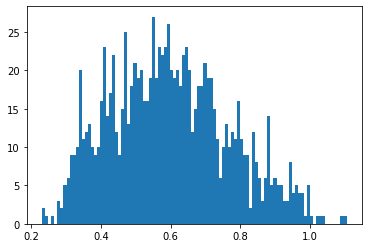

In [66]:
hist(diff_norms, bins=100)

1
0.0 1.1048119068145752 0.5980712170682496


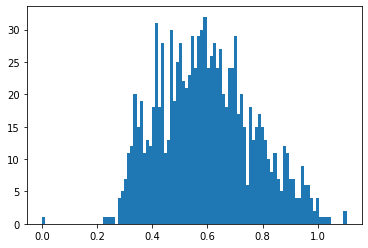

In [67]:
for subject_id_t in list(facial_ids.keys())[:1]:
    print(subject_id_t)
    diff_norms = []
    for subject_id_b in facial_ids:
        diff_norms.append(norm(facial_ids[subject_id_t] - facial_ids[subject_id_b]))
    diff_norms = np.asarray(diff_norms)
    print(diff_norms.min(), diff_norms.max(), diff_norms.mean())
    hist(diff_norms, bins=100)

In [68]:
ref_facial_ids = facial_ids

In [92]:
with open("face_vijnana_yolov3_win.json", 'r') as f:
    conf = json.load(f)

In [93]:
import face_identification

In [94]:
importlib.reload(face_identification)

<module 'face_identification' from 'D:\\topcoder\\face_recog\\src\\space\\face_identification.py'>

In [95]:
fr = face_identification.FaceIdentifier(conf)

Instructions for updating:
Use tf.cast instead.


In [96]:
fr.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
input_p (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
input_n (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
base (Model)                    (None, 13, 13, 1024) 40620640    input_a[0][0]                    
                                                                 input_p[0][0]                    
          

In [98]:
base = fr.model.get_layer('base')

In [100]:
base.output_shape[1:]

(13, 13, 1024)

In [101]:
base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_39 (ZeroPadding2 (None, 418, 418, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         zero_padding2d_39[0][0]          
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_re_l

In [14]:
db = pd.read_csv('subject_image_db.csv')
db = db.iloc[:, 1:]
db_g = db.groupby('subject_id')

In [15]:
subject_ids = db_g.groups.keys()

In [16]:
facial_ids_dict= {}

In [17]:
subject_id = 1
df = db_g.get_group(subject_id)
images = []
for ff in list(df.iloc[:, 1]):
    image = imread(os.path.join('subject_faces', ff))
    images.append(image/255)
images = np.asarray(images)
facial_ids = fr.fid_extractor.predict(images)
facial_ids_dict[subject_id] = facial_ids
facial_ids.shape

(2, 64)

In [18]:
images[0].mean(), images[0].max()

(0.33885938466856186, 0.792156862745098)

In [19]:
norm(facial_ids[1] - facial_ids[0]) 

0.6339962482452393

In [20]:
norm(facial_ids[1])

1.0

In [21]:
norm(facial_ids[0] - ref_facial_ids[1])

0.31699812412261963

In [22]:
for i in range(facial_ids.shape[1]):
    print(facial_ids[0,i], facial_ids[1,i], ref_facial_ids[1][i])

0.0 0.0 0.0
0.13209204 0.10122908 0.116660565
0.1779783 0.0 0.08898915
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.06827514 0.03413757
0.0 0.0 0.0
0.09583154 0.0 0.04791577
0.0 0.0 0.0
0.095636934 0.056734137 0.07618554
0.0 0.0 0.0
0.17804354 0.15667246 0.16735801
0.0 0.0 0.0
0.0 0.11982947 0.059914734
0.0 0.0 0.0
0.0 0.0 0.0
0.3648225 0.36048463 0.36265355
0.0 0.0 0.0
0.34382787 0.26104456 0.30243623
0.0 0.303261 0.1516305
0.0 0.0 0.0
0.0 0.0 0.0
0.1129849 0.0 0.05649245
0.0 0.0 0.0
0.0 0.0 0.0
0.12511502 0.0 0.06255751
0.0 0.021784527 0.010892264
0.0 0.0 0.0
0.17774335 0.16308546 0.1704144
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.08727419 0.043637093
0.29922163 0.26390207 0.28156185
0.0 0.0 0.0
0.06007005 0.0 0.030035025
0.0 0.12578288 0.06289144
0.0 0.0 0.0
0.0 0.0 0.0
0.104970194 0.0 0.052485097
0.23774455 0.19571386 0.21672921
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.14961724 0.09623521 0.12292622
0.08503348 0.27368355 0.17935851
0.0 0.0 0.0
0.4709177 0.4353036 0.45311064


In [23]:
subject_id = 2
df = db_g.get_group(subject_id)
images = []
for ff in list(df.iloc[:, 1]):
    image = cv.imread(os.path.join('subject_faces', ff))
    r = image[:, :, 0].copy()
    g = image[:, :, 1].copy()
    b = image[:, :, 2].copy()
    image[:, :, 0] = b
    image[:, :, 1] = g
    image[:, :, 2] = r 
    images.append(image/255)
images = np.asarray(images)
facial_ids = fr.fid_extractor.predict(images)
facial_ids_dict[subject_id] = facial_ids
facial_ids.shape

(13, 64)

In [24]:
for i in range(facial_ids.shape[0]): print(norm(facial_ids[i]))

1.0
1.0
0.9999999403953552
1.0
1.0000001192092896
1.0
1.0
1.0
1.0
1.0
0.9999999403953552
1.0
1.0


In [25]:
norm(facial_ids[0] - facial_ids[1]) 

0.0934089943766594

In [26]:
dists = []
for i in range(facial_ids.shape[0] - 1):
    for j in range(i + 1, facial_ids.shape[0]):
        dists.append(norm(facial_ids[i] - facial_ids[j]))
dists = np.asarray(dists)
print(dists.min(), dists.max(), dists.mean())

0.09184958040714264 0.6300374865531921 0.2816047358016173


In [27]:
norm(facial_ids_dict[1][0] - facial_ids[1][1])

2.2123892307281494

In [28]:
subject_id = 3
df = db_g.get_group(subject_id)
images = []
for ff in list(df.iloc[:, 1]):
    image = imread(os.path.join('subject_faces', ff))
    images.append(image/255)
images = np.asarray(images)

In [29]:
facial_ids = fr.fid_extractor.predict(images)

In [30]:
dists = []
for i in range(facial_ids.shape[0] - 1):
    for j in range(i + 1, facial_ids.shape[0]):
        dists.append(norm(facial_ids[i] - facial_ids[j]))
dists = np.asarray(dists)
print(dists.min(), dists.max(), dists.mean())

0.142851322889328 0.8016296029090881 0.3784285101389128


In [31]:
image = imread(os.path.join('subject_faces', ff))

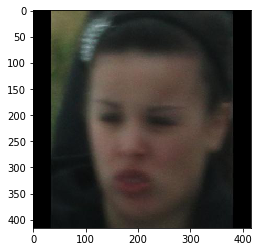

In [32]:
imshow(image)

In [33]:
from skimage.io import imread, imsave
from skimage.transform import resize 
from skimage.draw import polygon_perimeter, set_color

from PIL import Image, ImageFont, ImageDraw

In [34]:
imageObject = Image.fromarray(image, mode='RGB')
imageDraw = ImageDraw.Draw(imageObject)

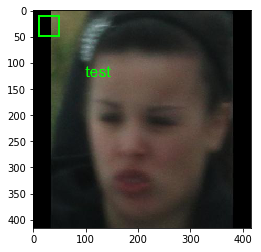

In [35]:
font = ImageFont.truetype('arial.ttf', 30)
imageDraw.text((100, 100), 'test', fill=(0,255,0), font=font)
imageDraw.rectangle([10, 10, 50, 50], outline=(0,255,0), width=3)
imshow(np.asarray(imageObject))

In [36]:
res = fr.fid_extractor.predict(image[np.newaxis, ...]/255)

In [37]:
res.shape

(1, 64)

In [38]:
norm(res)

1.0

In [39]:
b, g, t = cv.split(image)

In [40]:
m_image = cv.merge((b, np.zeros(shape=(416,416), dtype=uint8), np.zeros(shape=(416,416), dtype=uint8)))

In [41]:
ff

'fd5723edbcc50150c7cdbd06fe2f9111_3_2399_2776.jpg'

In [42]:
image2 = imread(os.path.join('subject_faces', ff))

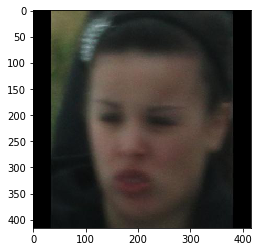

In [43]:
imshow(image2)

In [47]:
db = pd.read_csv('subject_image_db.csv')
db = db.iloc[:, 1:]
db_g = db.groupby('subject_id')
same_dists = []
diff_dists = []

with h5py.File('subject_facial_ids.h5', 'r') as f:
    subject_ids = list(db_g.groups.keys())
    
    # Same face identity pairs.
    print('Same face identity pairs.')
    for c, subject_id in enumerate(subject_ids):
        print(c + 1, '/', len(subject_ids), end='\r')
        
        if subject_id == -1:
            continue
        
        # Get face images of a subject id.
        df = db_g.get_group(subject_id)
        file_names = list(df.iloc[:, 1])
        
        # Check exception.
        if len(file_names) < 2: continue
        
        for i in range(len(file_names)): 
            same_dists.append(norm(ref_facial_ids[subject_id] - f[file_names[i]].value)) 

    print()

    # Determine pairs of different face identity randomly.
    idxes = range(len(subject_ids))
    num_pairs = len(subject_ids) // 2
    pairs = np.random.choice(idxes, size=(num_pairs, 2), replace=False)
        
    # Different face identity pairs.b
    print('Different face identity pairs.')
    for i in range(pairs.shape[0]):
        print(i + 1, '/', pairs.shape[0], end='\r')
        
        k = pairs[i, 0]
        l = pairs[i, 1]

        if subject_ids[k] == -1 or subject_ids[l] == -1:
            continue            

        comp_df = db_g.get_group(subject_ids[l])
        comp_file_names = list(comp_df.iloc[:, 1])
                        
        for comp_fn in comp_file_names: 
            diff_dists.append(norm(ref_facial_ids[subject_ids[k]] - f[comp_fn].value))            
        
same_dists = np.asarray(same_dists)
diff_dists = np.asarray(diff_dists)

Same face identity pairs.
1081 / 1081 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 1081 / 10811081
Different face identity pairs.


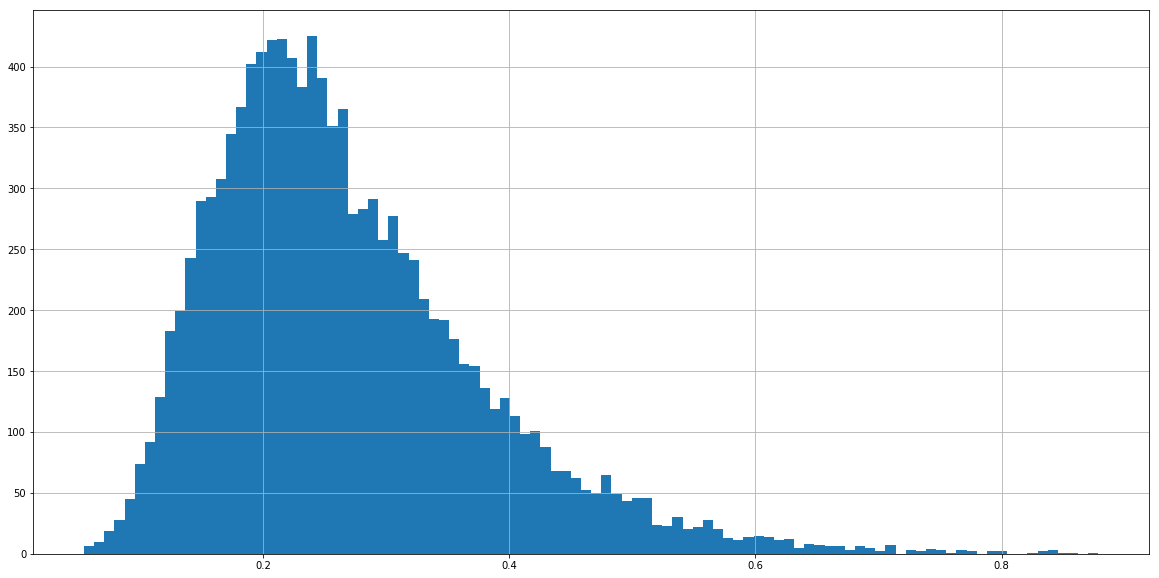

In [48]:
figure(figsize=(20,10))
hist(same_dists, bins=100)
grid()

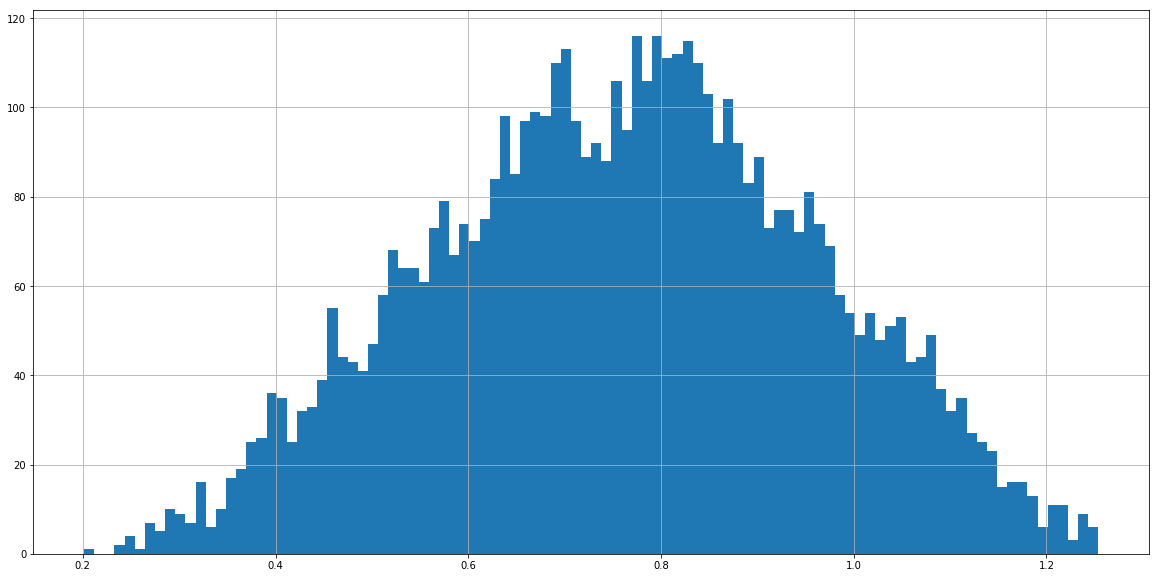

In [49]:
figure(figsize=(20,10))
hist(diff_dists, bins=100)
grid()

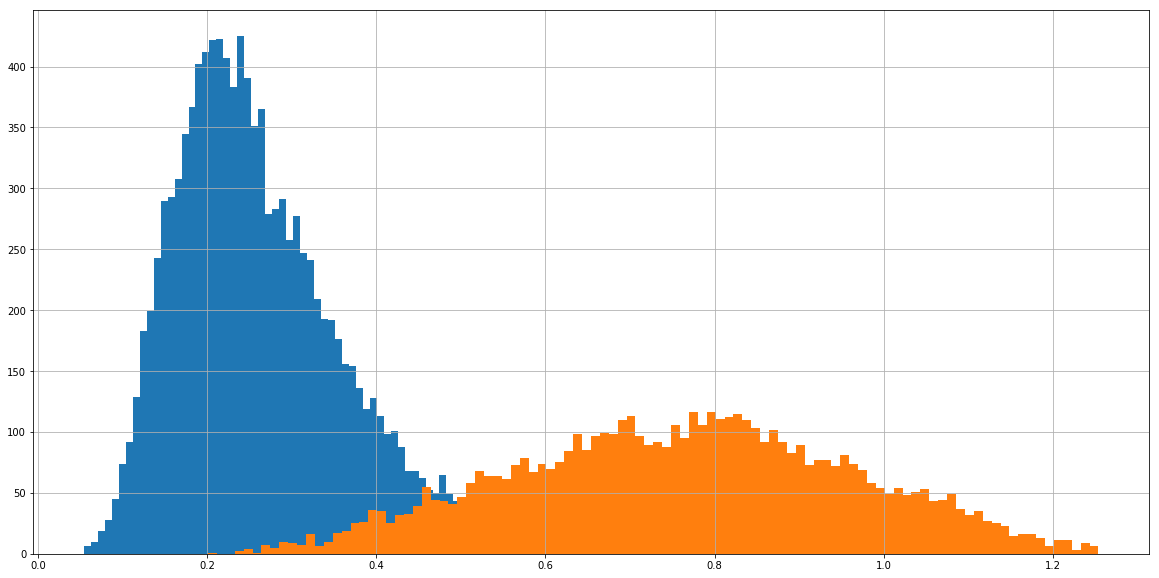

In [50]:
figure(figsize=(20,10))
hist(same_dists, bins=100)
hist(diff_dists, bins=100)
grid()

In [109]:
for subject_id in list(subject_ids)[:100]:
    df = db_g.get_group(subject_id)
    images = []
    for ff in list(df.iloc[:, 1]):
        image = imread(os.path.join('subject_faces', ff))
        images.append(image/255)
    images = np.asarray(images)
    facial_ids = fr.fid_extractor.predict(images)
    
    dists = []
    for i in range(facial_ids.shape[0] - 1):
        for j in range(i + 1, facial_ids.shape[0]):
            dists.append(norm(facial_ids[i] - facial_ids[j]))
    dists = np.asarray(dists)
    
    ref_dists = []
    for i in range(facial_ids.shape[0]):
        ref_dists.append(norm(ref_facial_ids[subject_id] - facial_ids[i]))
    ref_dists = np.asarray(ref_dists)
    
    #if len(dists) != 0: print(subject_id, dists.min(), dists.max(), dists.mean())
    if len(dists) != 0: print(subject_id, ref_dists.min(), ref_dists.max(), ref_dists.mean()) 

1 0.31699812412261963 0.31699812412261963 0.31699812412261963
2 0.08188753575086594 0.4054949879646301 0.18553479073139337
3 0.1484779715538025 0.6170151829719543 0.26271721135292736
5 0.19021432101726532 0.6365389823913574 0.36230561988694326
6 0.11527179926633835 0.44185009598731995 0.23848825879395008
7 0.16121390461921692 0.41147810220718384 0.24995450675487518
8 0.13463760912418365 0.3316146731376648 0.23080525050560632
9 0.15575015544891357 0.44398587942123413 0.28678986572083975
10 0.28028953075408936 0.28028953075408936 0.28028953075408936
11 0.42411935329437256 0.5666417479515076 0.5062295347452164
12 0.12864883244037628 0.6153002977371216 0.2331407639910193
13 0.31551414728164673 0.31551414728164673 0.31551414728164673
16 0.11225592344999313 0.5599376559257507 0.23820211353801912
17 0.3693578839302063 0.5138313174247742 0.4329121212164561
18 0.3331071436405182 0.4633590579032898 0.38914355635643005
20 0.42223650217056274 0.42223650217056274 0.42223650217056274
21 0.3092263340

In [110]:
for subject_id in list(subject_ids)[:100]:
    df = db_g.get_group(subject_id)
    images = []
    for ff in list(df.iloc[:, 1]):
        image = imread(os.path.join('subject_faces', ff))
        images.append(image/255)
    images = np.asarray(images)
    facial_ids = fr.fid_extractor.predict(images)
    
    dists = []
        
    for i in range(facial_ids.shape[0]):
        for subject_id_p in list(subject_ids)[:100]:
            if subject_id_p == subject_id: continue
            dists.append(norm(facial_ids[i] - ref_facial_ids[subject_id_p]))
                
    dists = np.asarray(dists)
        
    if len(dists) != 0: print(subject_id, dists.min(), dists.max(), dists.mean())

1 0.32682424783706665 1.2354539632797241 0.6279167690963456
2 0.4623224139213562 1.1534909009933472 0.872683232781863
3 0.2979465425014496 1.1764167547225952 0.784358753162889
5 0.2493106722831726 1.2194240093231201 0.6306898415604711
6 0.24852897226810455 1.1145596504211426 0.6116204857750974
7 0.24132616817951202 1.196224570274353 0.6219323082855254
8 0.2278444617986679 1.2935820817947388 0.6586079824000898
9 0.21413087844848633 1.224406123161316 0.6402781238459577
10 0.37052327394485474 1.2311433553695679 0.6564201396523099
11 0.22488977015018463 1.2181252241134644 0.6992323739134302
12 0.22202083468437195 1.1764651536941528 0.6085586018829351
13 0.25683656334877014 1.1618164777755737 0.6673696765092888
16 0.1957782655954361 1.222368836402893 0.5907984091574068
17 0.3465452492237091 1.1574393510818481 0.7613928338092586
18 0.21062570810317993 1.1831930875778198 0.6801464117386125
20 0.3563513159751892 1.1020655632019043 0.7345768496243641
21 0.3090371787548065 1.272788405418396 0.71

In [83]:
from keras import backend as K
from keras.layers import Layer, Input, Flatten, Dense
from keras.models import Model

class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.rbm_weight = self.add_weight(name='rbm_weight'
                                 , shape=(input_shape[1], self.output_dim)
                                 , initializer='uniform' # Which initializer is optimal?
                                 , trainable=True)

        self.hidden_bias = self.add_weight(name='rbm_hidden_bias'
                                           , shape=(self.output_dim, )
                                           , initializer='uniform'
                                           , trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.sigmoid(K.dot(x, self.rbm_weight) + self.hidden_bias) # Float type?

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def fit(self, x):
        pass

In [85]:
input1 = Input(shape=(100,))
x = MyLayer(10)(input1)
x = Dense(10, activation='softmax')(x)
model = Model(input1, x)
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(np.random.rand(1,100), np.random.rand(1,10))

Epoch 1/1
1/1 [==============================] - 8s 8s/step - loss: 11.2390


In [3]:
import numpy as np

from keras import backend as K
from keras.layers import Layer, Input
from tensorflow.keras import initializers

class RBM(Layer):
    """Restricted Boltzmann Machine based on Keras."""
    def __init__(self, hps, output_dim, name=None, **kwargs):
        self.hps = hps
        self.output_dim = output_dim
        self.name = name
        super(RBM, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.rbm_weight = self.add_weight(name='rbm_weight'
                                 , shape=(input_shape[1], self.output_dim)
                                 , initializer='uniform' # Which initializer is optimal?
                                 , trainable=True)

        self.hidden_bias = self.add_weight(name='rbm_hidden_bias'
                                           , shape=(self.output_dim, )
                                           , initializer='uniform'
                                           , trainable=True)
        self.visible_bias = K.variable(initializers.get('uniform')((input_shape[1], ))
                            , dtype=K.floatx()
                            , name='rbm_visible_bias')
        
        # Make symbolic computation objects.
        # Transform visible units.
        self.input_visible = K.placeholder(shape=(None, input_shape[1]), name='input_visible')
        self.transform = K.sigmoid(K.dot(self.input_visible, self.rbm_weight) + self.hidden_bias)
        self.transform_func = K.function([self.input_visible], [self.transform])
  
        # Transform hidden units.      
        self.input_hidden = K.placeholder(shape=(None, self.output_dim), name='input_hidden')
        self.inv_transform = K.sigmoid(K.dot(self.input_hidden, K.transpose(self.rbm_weight)) + self.visible_bias)
        self.inv_transform_func = K.function([self.input_hidden], [self.inv_transform])
        
        super(RBM, self).build(input_shape)
        
    def call(self, x):
        return K.sigmoid(K.dot(x, self.rbm_weight) + self.hidden_bias) # Float type?
    
    def transform(self, v):
        return self.transform_func(v)
    
    def inv_transform(self, h):
        return self.inv_transform_func(h)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def fit(self, V, verbose=1):
        """Train RBM with the data V.
        
        Parameters
        ----------
        V : 2d numpy array
            Visible data (batch size x input_dim).
        verbose : integer
            Verbose mode (default, 1).
        """
        num_step = V.shape[0] // self.hps['batch_size'] \
            if V.shape[0] % self.hps['batch_size'] == 0 else V.shape[0] // self.hps['batch_size'] + 1 # Exception processing?
        
        # Contrastive divergence.
        v_pos = self.input_visible
        h_pos = self.transform
        v_neg = K.cast(K.less(K.random_uniform(shape=(self.hps['batch_size'], V.shape[1]))
                       , K.sigmoid(K.dot(h_pos, K.transpose(self.rbm_weight)) + self.visible_bias))
                       , dtype=np.float32)
        h_neg = K.sigmoid(K.dot(v_neg, self.rbm_weight) + self.hidden_bias)
        update = K.transpose(K.transpose(K.dot(K.transpose(v_pos), h_pos)) \
                             - K.dot(K.transpose(h_neg), v_neg))
        self.rbm_weight_update_func = K.function([self.input_visible], 
                                [K.update_add(self.rbm_weight, self.hps['lr'] * update)])
        self.hidden_bias_update_func = K.function([self.input_visible], 
                                [K.update_add(self.hidden_bias, self.hps['lr'] \
                                * (K.sum(h_pos, axis=0) - K.sum(h_neg, axis=0)))])
        self.visible_bias_update_func = K.function([self.input_visible], 
                                [K.update_add(self.visible_bias, self.hps['lr'] \
                                * (K.sum(v_pos, axis=0) - K.sum(v_neg, axis=0)))])
        
        for k in range(self.hps['epochs']):
            if verbose == 1:
                print(k, '/', self.hps['epochs'], ' epochs')
                
            for i in range(num_step):
                if i == (num_step - 1):
                    # Contrastive divergence.
                    v_pos = self.input_visible
                    h_pos = self.transform
                    v_neg = K.cast(K.less(K.random_uniform(shape=(V.shape[0] \
                                   - int(i*self.hps['batch_size']), V.shape[1])) #?
                                   , K.sigmoid(K.dot(h_pos, K.transpose(self.rbm_weight)) \
                                   + self.visible_bias)), dtype=np.float32)
                    h_neg = K.sigmoid(K.dot(v_neg, self.rbm_weight) + self.hidden_bias)
                    update = K.transpose(K.transpose(K.dot(K.transpose(v_pos), h_pos)) \
                                         - K.dot(K.transpose(h_neg), v_neg))
                    self.rbm_weight_update_func = K.function([self.input_visible], 
                            [K.update_add(self.rbm_weight, self.hps['lr'] * update)])
                    self.hidden_bias_update_func = K.function([self.input_visible], 
                            [K.update_add(self.hidden_bias, self.hps['lr'] \
                            * (K.sum(h_pos, axis=0) - K.sum(h_neg, axis=0)))])
                    self.visible_bias_update_func = K.function([self.input_visible], 
                            [K.update_add(self.visible_bias, self.hps['lr'] \
                            * (K.sum(v_pos, axis=0) - K.sum(v_neg, axis=0)))])

                    V_batch = [V[int(i*self.hps['batch_size']):V.shape[0]]]
                    
                    # Train.
                    self.rbm_weight_update_func(V_batch)
                    self.hidden_bias_update_func(V_batch)
                    self.visible_bias_update_func(V_batch)
                else:
                    V_batch = [V[int(i*self.hps['batch_size']):int((i+1)*self.hps['batch_size'])]]
                    
                    # Train.
                    self.rbm_weight_update_func(V_batch)
                    self.hidden_bias_update_func(V_batch)
                    self.visible_bias_update_func(V_batch)  

Using TensorFlow backend.


In [4]:
hps = {}
hps['lr'] = 0.1
hps['batch_size'] = 1
hps['epochs'] = 10
hps['beta_1'] = 0.99
hps['beta_2'] = 0.99
hps['decay'] = 0.0

rbm_layer = RBM(hps, 10)
input1 = Input(shape=(10, 10, 3))
x = Flatten()(input1)
x = rbm_layer(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=[input1], outputs=[output])
opt = optimizers.Adam(lr=hps['lr']
                                , beta_1=hps['beta_1']
                                , beta_2=hps['beta_2']
                                , decay=hps['decay'])

model.compile(optimizer=opt, loss='mse')

NameError: name 'Flatten' is not defined

In [47]:
model.predict(np.random.rand(1,10,10,3))

array([[0.05225093, 0.08817174, 0.16123906, 0.06477234, 0.12430384,
        0.06368855, 0.09730622, 0.1456283 , 0.0880848 , 0.11455426]],
      dtype=float32)

In [48]:
rbm_layer.fit(np.random.rand(1, 300))

0 / 10  epochs
1 / 10  epochs
2 / 10  epochs
3 / 10  epochs
4 / 10  epochs
5 / 10  epochs
6 / 10  epochs
7 / 10  epochs
8 / 10  epochs
9 / 10  epochs


In [49]:
model.fit(np.random.rand(10,10,10,3), np.random.rand(10, 10))

Epoch 1/1
10/10 [==============================] - 8s 807ms/step - loss: 0.2910


In [52]:
input1 = Input(shape=(10,))
x = Lambda(lambda x: K.l2_normalize(x, axis=1))(input1)
model = Model(input1, x)

In [74]:
res = model.predict(np.random.rand(2,10))

In [75]:
res.shape

(2, 10)

In [77]:
norm(res[0])

1.0

In [59]:
input1 = Input(shape=(10,))
input2 = Input(shape=(10,))
x = Lambda(lambda x: K.cast(K.less(x[0], x[1]), dtype=float32))([input1, input2])
model = Model(inputs=[input1, input2], outputs=[x])

In [60]:
model.predict([np.random.rand(1,10), np.random.rand(1, 10)])

array([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [62]:
base = MobileNetV2(include_top = False)

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\keras_applications\mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 4s 0us/step


In [63]:
base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [2]:
help(input)

Help on method raw_input in module ipykernel.kernelbase:

raw_input(prompt='') method of ipykernel.ipkernel.IPythonKernel instance
    Forward raw_input to frontends
    
    Raises
    ------
    StdinNotImplentedError if active frontend doesn't support stdin.



In [4]:
res = input('>')

>hello


In [5]:
res

'hello'

In [7]:
print('Score {0: f}'.format(1.8))

Score  1.800000


In [5]:
hps

{'lr': 0.1,
 'batch_size': 1,
 'epochs': 10,
 'beta_1': 0.99,
 'beta_2': 0.99,
 'decay': 0.0}

In [6]:
import json

In [7]:
res = json.dumps(hps)

In [8]:
res

'{"lr": 0.1, "batch_size": 1, "epochs": 10, "beta_1": 0.99, "beta_2": 0.99, "decay": 0.0}'

In [9]:
hps['flag'] = True

In [10]:
res = json.dumps(hps)
res

'{"lr": 0.1, "batch_size": 1, "epochs": 10, "beta_1": 0.99, "beta_2": 0.99, "decay": 0.0, "flag": true}'

In [13]:
res = json.loads('{"mode" : "train", "hps" : {"lr" : 0.001, "beta_1" : 0.99, "beta_2" : 0.99, "decay" : 0.0, "epochs" : 1, "batch_size" : 128}, "rbm_hps" : { "lr" : 0.001, "epochs" : 1, "batch_size" : 128}, "nn_arch" : {"output_dim" : 128}, "model_loading": false}')

In [16]:
type(res)

dict

In [20]:
p = np.random.rand(10)
p

array([0.71868607, 0.7595842 , 0.10236726, 0.63356467, 0.08557064,
       0.14795317, 0.66096607, 0.94096301, 0.87105102, 0.98301912])

In [21]:
sample = np.identity(10)
sample

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [19]:
p = p/p.sum()
res = np.random.multivariate_normal(p, np.identity(10))
res

array([ 0.72697841, -0.38562431, -0.47842945,  0.40895143, -0.24434335,
       -0.29382098, -1.31171756,  0.83955232, -1.66124913,  0.26366205])

In [17]:
sol_df = pd.read_csv('d:\\topcoder\\face_recog\\src\\space\\solution.csv', header=None)

In [18]:
res = sol_df.iloc[0]

In [19]:
type(res)

pandas.core.series.Series

In [20]:
res

0    1389.jpg
1         301
2     2495.47
3      1049.5
4     256.543
5      326.51
6    0.773768
Name: 0, dtype: object

In [21]:
sol_df.iloc[0, :]

0    1389.jpg
1         301
2     2495.47
3      1049.5
4     256.543
5      326.51
6    0.773768
Name: 0, dtype: object

In [26]:
sol_df.loc[0]

0    1389.jpg
1         301
2     2495.47
3      1049.5
4     256.543
5      326.51
6    0.773768
Name: 0, dtype: object

In [25]:
import pandas as pd
import numpy as np
sample = pd.DataFrame([(0, 0, 1), (0, 1, 10), (1, 0, 2), (1, 1, 3)])

In [26]:
sample.sort_values(by=2, ascending=False)

,0,1,2
1,0,1,10
3,1,1,3
2,1,0,2
0,0,0,1


In [27]:
df = sample.iloc[2]
df

0    1
1    0
2    2
Name: 2, dtype: int64

In [28]:
df.iloc[2] = 100

In [29]:
sample

,0,1,2
0,0,0,1
1,0,1,10
2,1,0,100
3,1,1,3


In [30]:
res = sample[sample[2] != 100]

In [31]:
res

,0,1,2
0,0,0,1
1,0,1,10
3,1,1,3


In [34]:
res_g = res.groupby(2)

In [35]:
res_g.groups.keys()

dict_keys([1, 3, 10])

In [1]:
cd ../src/space

d:\topcoder\face_recog\src\space


In [2]:
import pdb

In [78]:
import numpy as np
import pandas as pd

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax
                 , objness = None
                 , classes = None
                 , anchor = None
                 , subject_id = -1):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes
        self.anchor = anchor
        self.subject_id = subject_id

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return np.min([self.score, 1.0])
        
    def get_relative_bb(self, width, height):
        left = int(self.xmin/width * 100.)
        top = int(self.ymin/height * 100.)
        width = int((self.xmax - self.xmin)/width * 100.)
        height = int((self.ymax - self.ymin)/height * 100.)
        
        return (left, top, width, height)

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union    

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 

sol_path='D:\\topcoder\\face_recog\\resource\\solution_training_fd.csv'
gt_path='D:\\topcoder\\face_recog\\resource\\training.csv'

def evaluate_fd(gt_path, sol_path, iou_th):
    # Load ground truth, predicted results and calculate IoU.
    sol_df = pd.read_csv(sol_path, header=None)
    sol_df = pd.concat([sol_df, pd.DataFrame(np.zeros(shape=(sol_df.shape[0]), dtype=np.float64), columns=[7])], axis=1) # IoU
    sol_df.iloc[:, 6] = -1.0
    sol_df_g = sol_df.groupby(0) #?
        
    gt_df = pd.read_csv(gt_path)
    gt_df = pd.concat([gt_df, pd.DataFrame(np.zeros(shape=(gt_df.shape[0]), dtype=np.float64), columns=[8])], axis=1) # IoU
    gt_df.iloc[:, 7] = -1.0
    gt_df_g = gt_df.groupby('FILE') #?
    
    for k, image_id in enumerate(list(gt_df_g.groups.keys())):
        print(k, '/', len(gt_df_g.groups.keys()), ':', image_id, end='\r')
        df = gt_df_g.get_group(image_id)
        
        try:
            rel_sol_df = sol_df_g.get_group(image_id)
        except KeyError:
            continue
        
        gt_ious = {}
        
        for i in range(df.shape[0]):
            gt_ious[i] = []
            gt_sample = df.iloc[i]
            gt_sample_bb = BoundBox(gt_sample[3]
                                      , gt_sample[4]
                                      , gt_sample[3] + gt_sample[5]
                                      , gt_sample[4] + gt_sample[6])
                    
            # Check exception.
            if rel_sol_df.shape[0] == 0: continue
        
            # Calculate IoUs between a gt region and detected regions
            for j in range(rel_sol_df.shape[0]):
                rel_sol = rel_sol_df.iloc[j]
                rel_sol_bb = BoundBox(rel_sol[1]
                                      , rel_sol[2]
                                      , rel_sol[1] + rel_sol[3]
                                      , rel_sol[2] + rel_sol[4])
            
                iou = bbox_iou(gt_sample_bb, rel_sol_bb)
                if iou > 0.: #? 
                    gt_ious[i].append((i, j, iou))
        
        total_gt_ious = []
        for i in gt_ious:
            total_gt_ious += gt_ious[i]
            
        if len(total_gt_ious) == 0: continue
            
        total_gt_ious_df = pd.DataFrame(total_gt_ious)
        
        # IoU descending order sorting.
        total_gt_ious_df = total_gt_ious_df.sort_values(by=2, ascending=False)
        
        # Determine IoU for each detected region.
        while total_gt_ious_df.shape[0] != 0: #?
            df_p = total_gt_ious_df.iloc[0]
            i = int(df_p.iloc[0])
            j = int(df_p.iloc[1])
            iou = df_p.iloc[2]
            
            #df.iloc[i, -1] = iou 
            rel_sol_df.iloc[j, -1] = iou 
            
            # Remove assigned samples.
            total_gt_ious_df = total_gt_ious_df[total_gt_ious_df[0] != i]
            total_gt_ious_df = total_gt_ious_df[total_gt_ious_df[1] != j]
            
        if k == 0:
            res_df = rel_sol_df
        else:
            res_df = pd.concat([res_df, rel_sol_df])
        
    # Get the p-r curve.
    # Sort the solution in confidence descending order.
    res_df = res_df.sort_values(by=5, ascending=False)
    ps = []
    rs = []
    tp_count = 0
    count = 0
    gt_count = gt_df.shape[0]
    
    for i in range(gt_df.shape[0]):
        count +=1
        
        if i < res_df.shape[0] and res_df.iloc[i, 6] >= iou_th:
            tp_count += 1
            
        ps.append(tp_count / count)
        rs.append(tp_count / gt_count)
    
    ps = np.asarray(ps)
    rs = np.asarray(rs)
    
    func = interp1d(rs, ps)
    mAP = quad(lambda x: func(x), rs[0], rs[-1])
    
    return (ps, rs, mAP[0])

In [80]:
res_5 = evaluate_fd(gt_path, sol_path, 0.5)

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:172: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [81]:
res_5

(array([1.        , 1.        , 1.        , ..., 0.68895176, 0.68892611,
        0.68890047]),
 array([3.72217673e-05, 7.44435346e-05, 1.11665302e-04, ...,
        6.88900469e-01, 6.88900469e-01, 6.88900469e-01]),
 0.5553575171975492)

In [84]:
ps = res_5[0]
rs = res_5[1]

In [87]:
rs.shape

(26866,)

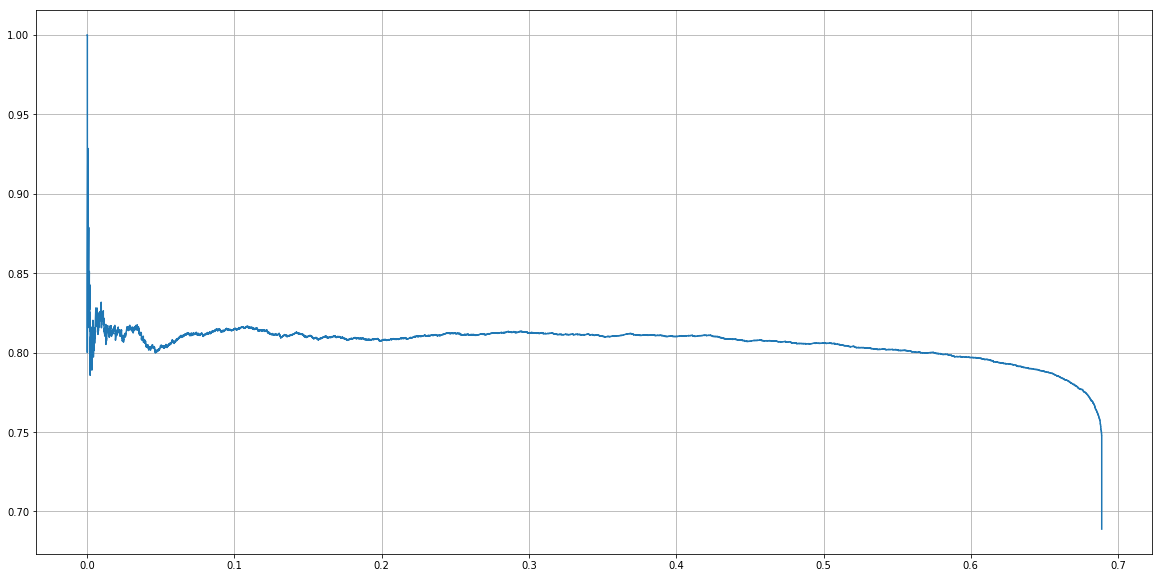

In [85]:
figure(figsize=(20,10))
plot(rs, ps)
grid()

In [49]:
for i in range(10): print(i, end='\r')

In [55]:
rs.max()

0.6889004689942678

In [56]:
rs.min()

3.722176728951091e-05

In [57]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [59]:
func = interp1d(rs, ps)

In [65]:
mAP = quad(lambda x: func(x), rs[0], rs[-1])

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


In [66]:
mAP

(0.5553826637303485, 5.407731600481913e-05)

In [67]:
ps_9, rs_9 = evaluate_fd(gt_path, sol_path, 0.9)

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [68]:
func = interp1d(rs_9, ps_9)
quad(lambda x: func(x), rs_9[0], rs_9[-1])

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


(4.525356868807096e-05, 1.2643668468998018e-07)

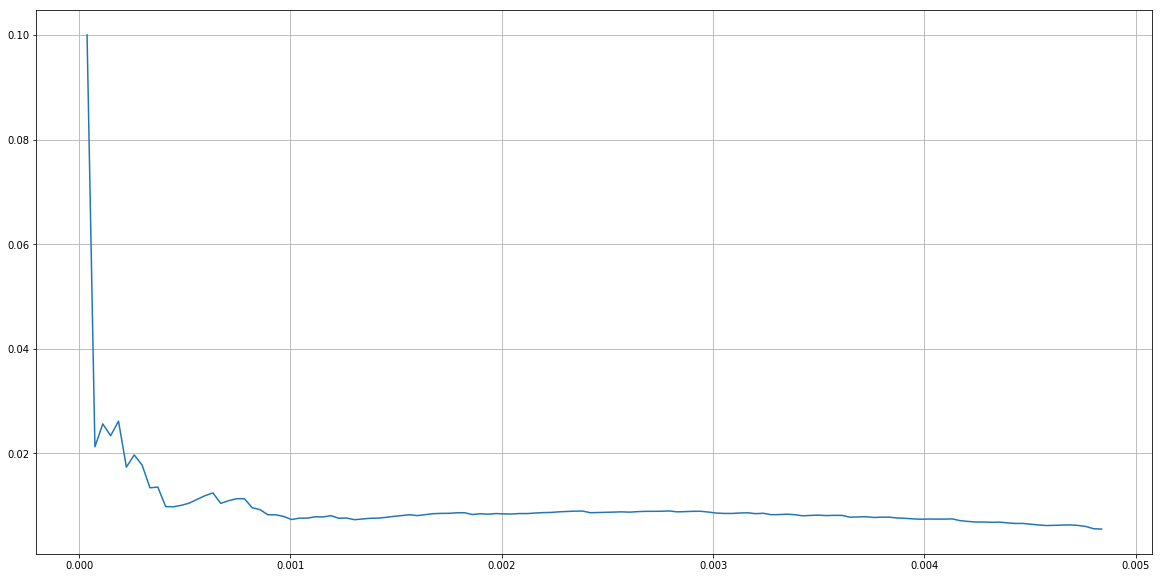

In [69]:
figure(figsize=(20,10))
plot(rs_9, ps_9)
grid()

In [70]:
rs_9.max()

0.004838829747636417

In [71]:
ps_7, rs_7 = evaluate_fd(gt_path, sol_path, 0.7)

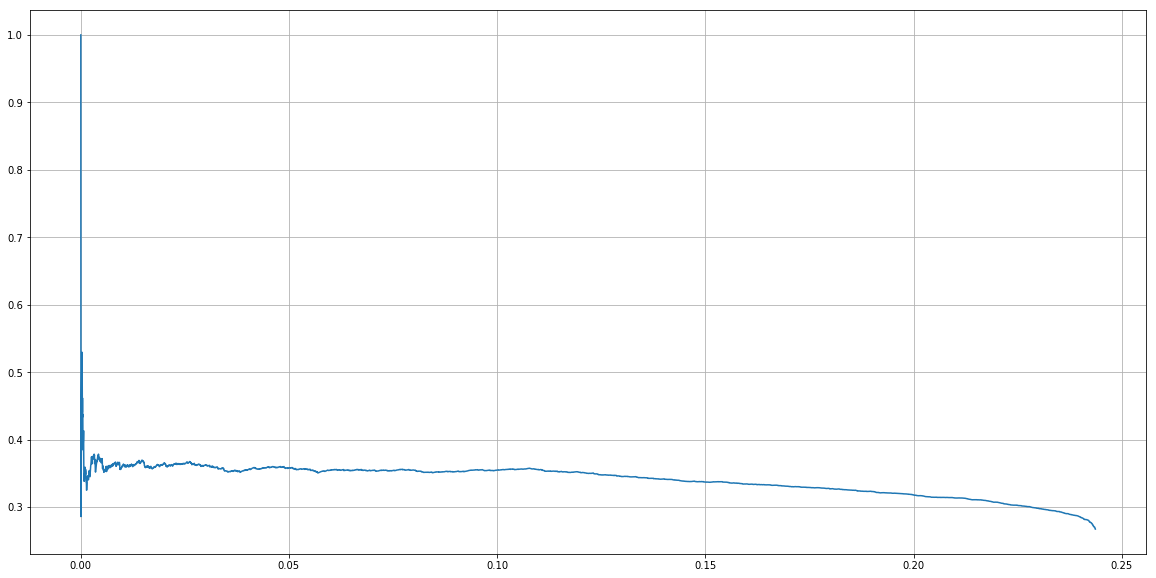

In [72]:
figure(figsize=(20,10))
plot(rs_7, ps_7)
grid()

In [73]:
func = interp1d(rs_7, ps_7)
quad(lambda x: func(x), rs_7[0], rs_7[-1])

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


(0.08274781890970458, 7.646777534869864e-06)

In [26]:
import h5py

In [53]:
f = h5py.File('sample.h5','w')

In [54]:
top = f.create_group('top')

In [55]:
top['0'] = np.random.rand(10)
top['1'] = np.random.rand(10)

In [56]:
top['0'].shape

(10,)

In [57]:
top['0'].attrs['id'] = 100

In [58]:
top['0'].attrs['id']

100

In [59]:
f.close()

In [60]:
ls

 D 드라이브의 볼륨: DATA
 볼륨 일련 번호: 40C4-7DAF

 D:\topcoder\face_recog\src\space 디렉터리

2019-05-29  오후 09:12    <DIR>          .
2019-05-29  오후 09:12    <DIR>          ..
2019-04-25  오후 05:13               158 .gitignore
2019-05-27  오후 11:10                92 __init__.py
2019-05-22  오전 02:45    <DIR>          __pycache__
2019-04-21  오후 10:08           744,004 db.csv
2019-05-22  오전 02:27           340,791 db_facial_id.pobj
2019-04-29  오후 11:01           604,649 es.csv
2019-05-29  오후 04:52             5,806 evaluate.py
2019-05-29  오후 07:14            40,904 face_detection.py
2019-05-22  오전 11:35       488,322,408 face_detector.h5
2019-05-29  오후 07:29            47,025 face_identification.py
2019-05-22  오전 02:26       620,573,520 face_identifier.h5
2019-05-17  오후 01:03       620,573,520 face_reidentifier.hd5
2019-05-29  오후 07:24             1,195 face_vijnana_yolov3.json
2019-05-03  오전 07:31         8,701,531 img_triplet_pairs.pickle
2019-05-29  오후 09:23             4,752 sample.h5
2019-04-25  오후

In [61]:
f = h5py.File('sample.h5','r')

In [62]:
f.keys()

KeysView(<HDF5 file "sample.h5" (mode r)>)

In [63]:
f.name

'/'

In [64]:
for name in f: print(name)

top


In [68]:
f['top']['0'].value

array([0.34670551, 0.57372988, 0.53244002, 0.37849571, 0.69450392,
       0.19979125, 0.62840678, 0.59146162, 0.85161414, 0.22788428])

In [98]:
sample = np.random.rand(10)
sample = sample <= 0.5

In [99]:
sample

array([ True, False,  True,  True,  True,  True, False, False,  True,
        True])

In [100]:
sample2 = sample.astype(np.int64)

In [101]:
sample2

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int64)

In [102]:
sample2.sum()

7

In [2]:
cd D:\topcoder\\face_recog\src\space

D:\topcoder\face_recog\src\space


In [3]:
import evaluate

Using TensorFlow backend.


In [6]:
import importlib
importlib.reload(evaluate)

<module 'evaluate' from 'D:\\topcoder\\face_recog\\src\\space\\evaluate.py'>

In [9]:
import pandas as pd
sample = pd.DataFrame({'a': range(10), 'b': range(10)})

In [14]:
sample.iloc[0, :]

a    0
b    0
Name: 0, dtype: int64

In [4]:
import h5py
f = h5py.File('p_r_curve.h5', 'r')

In [5]:
iou_ths = np.arange(0.5, 1.0, 0.05)
ps_ls = f['ps_ls'].value
rs_ls = f['rs_ls'].value
mAP_ls = f['mAP_ls'].value

In [12]:
help(legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line.set_label('Label via method')
        line, = ax.plot([1, 2, 3])
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label st

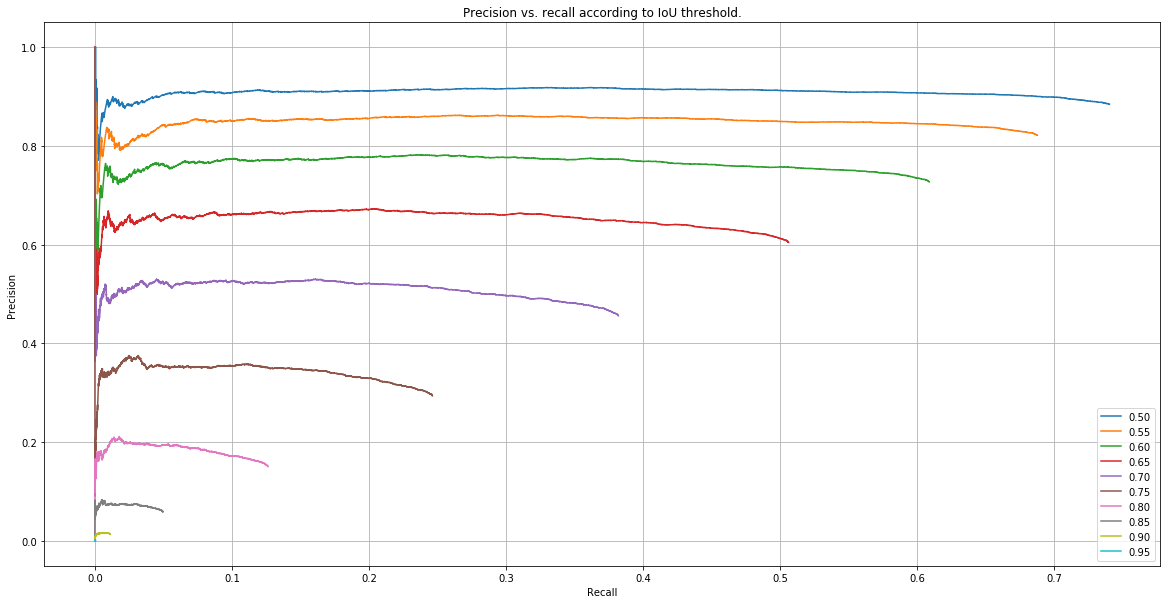

In [17]:
figure(figsize=(20, 10))
for i in range(len(iou_ths)):
    plot(rs_ls[i], ps_ls[i], label=str('{0:1.2f}'.format(iou_ths[i])))
title('Precision vs. recall according to IoU threshold.')
xlabel('Recall')
ylabel('Precision')
legend()
grid()

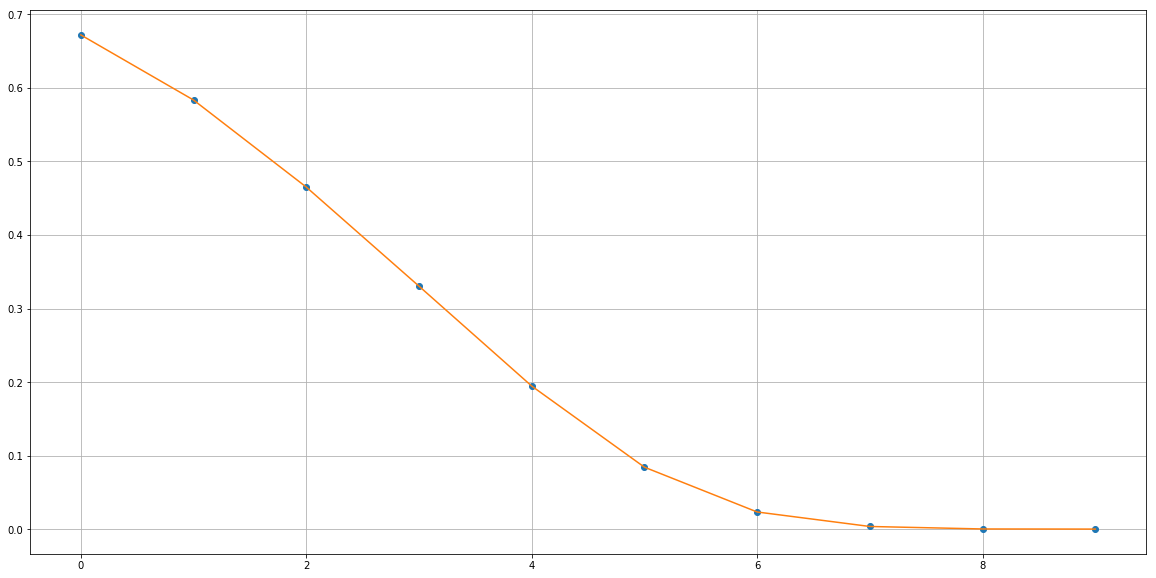

In [91]:
figure(figsize=(20, 10))
plot(mAP_ls, 'o')
plot(mAP_ls)
grid()

In [20]:
mAP_ls

array([6.72128728e-01, 5.83567271e-01, 4.65188992e-01, 3.30414787e-01,
       1.94553682e-01, 8.41897656e-02, 2.32625899e-02, 3.55186558e-03,
       1.72193758e-04, 6.35691127e-07])

In [21]:
mAP_ls.mean()

0.23570305108706485

In [50]:
input1 = Input(shape=(10,10,3))
x = Lambda(lambda x: K.sigmoid(x[..., 0:2]))(input1)
#x1 = Lambda(lambda x: K.expand_dims(K.sigmoid(x[..., 0:3])))(input1)
#x2 = Lambda(lambda x: K.expand_dims(K.log(x[..., 1])))(input1)
#x3 = Lambda(lambda x: K.expand_dims(K.exp(x[..., 2])))(input1)
#x = Concatenate()([x1, x2, x3])
model = Model(input1, x)

In [51]:
res = model.predict(np.ones(shape=(1,10,10,3)))

In [52]:
res.shape

(1, 10, 10, 2)

In [53]:
res

array([[[[0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586]],

        [[0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586]],

        [[0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586]],

    

In [3]:
f = h5py.File('face_pairs_dists.h5', 'r')

In [4]:
same_dists = f['sample_dists'].value
diff_dists = f['diff_dists'].value

In [5]:
same_dists.shape

(87899,)

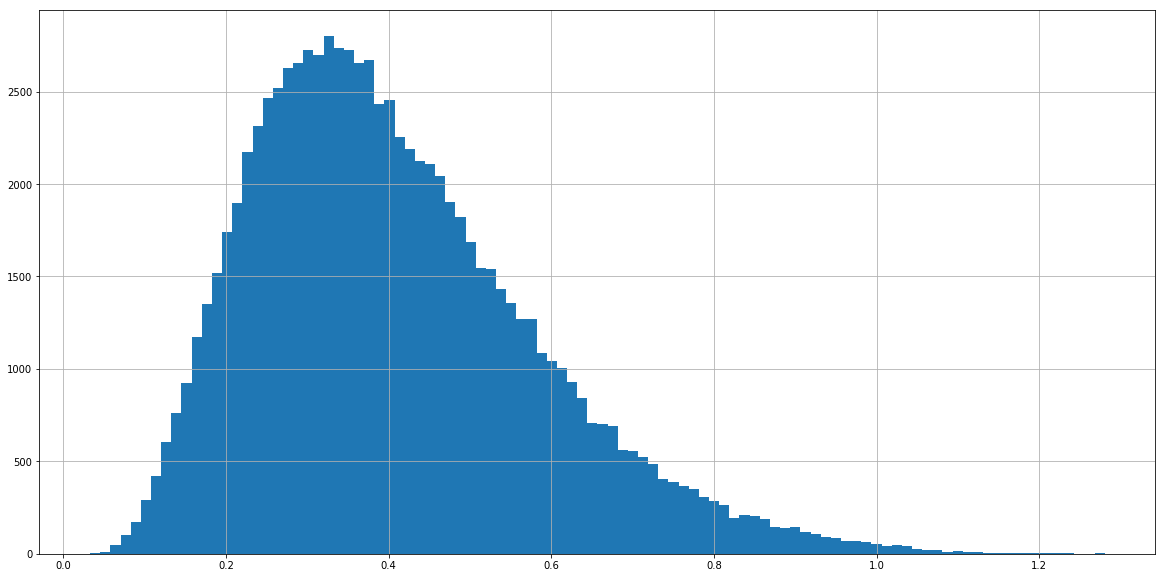

In [8]:
figure(figsize=(20,10))
hist(same_dists, bins=100)
grid()

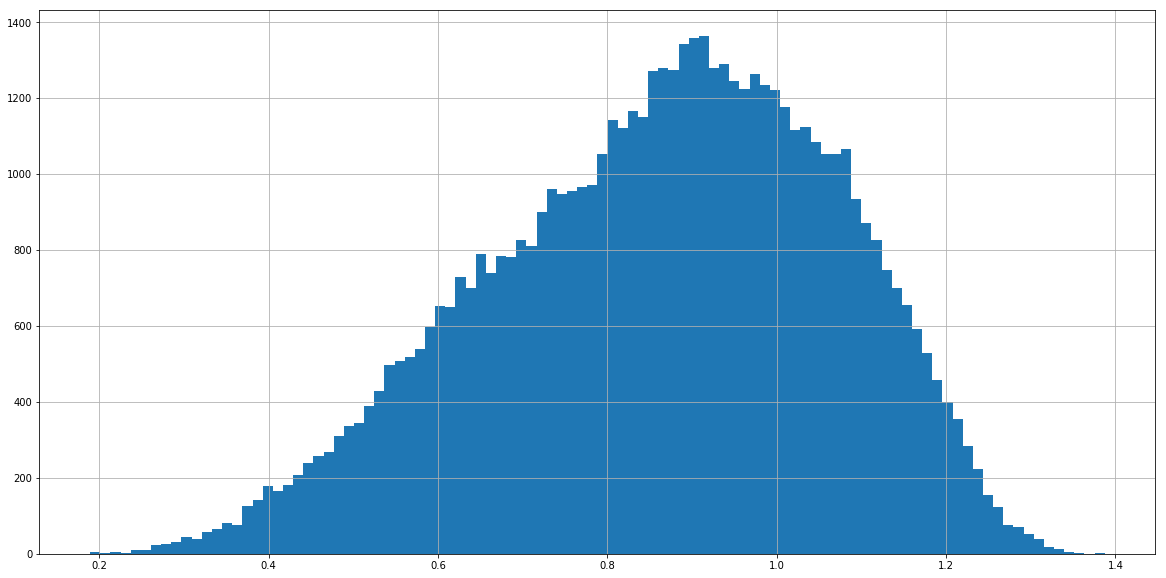

In [9]:
figure(figsize=(20,10))
hist(diff_dists, bins=100)
grid()

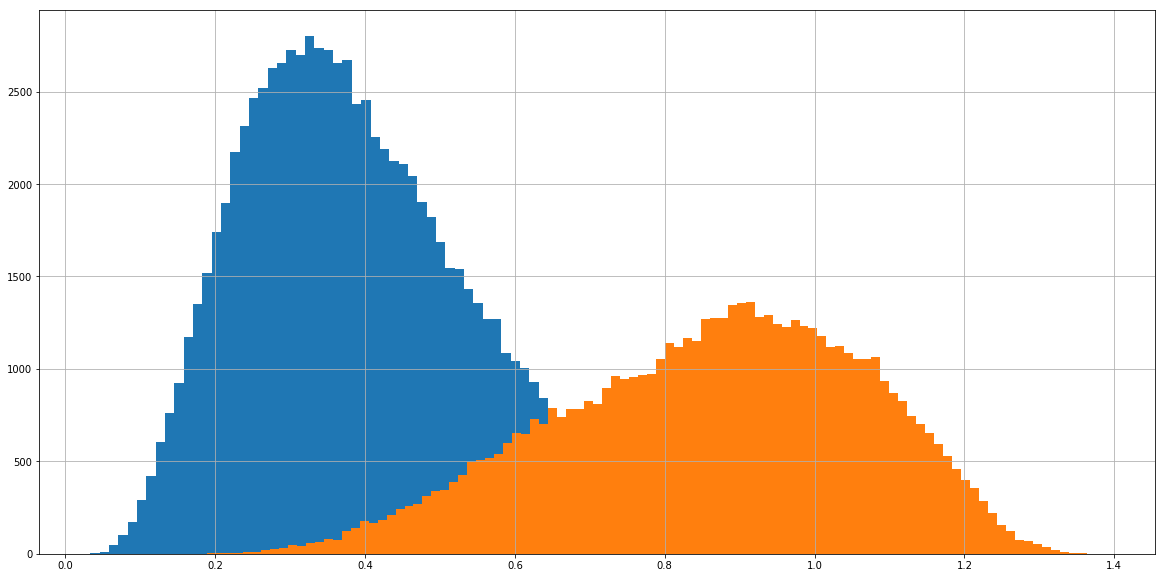

In [10]:
figure(figsize=(20,10))
hist(same_dists, bins=100)
hist(diff_dists, bins=100)
grid()

In [12]:
sample = np.arange(0.1, 1.0, 0.1)

In [13]:
sample

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [14]:
for i in sample: print(i)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


In [15]:
f.close()

In [16]:
f = h5py.File('var_far.h5', 'r')

In [17]:
sim_ths = f['sim_ths'].value
vars_p = f['vars'].value
fars_p = f['fars'].value

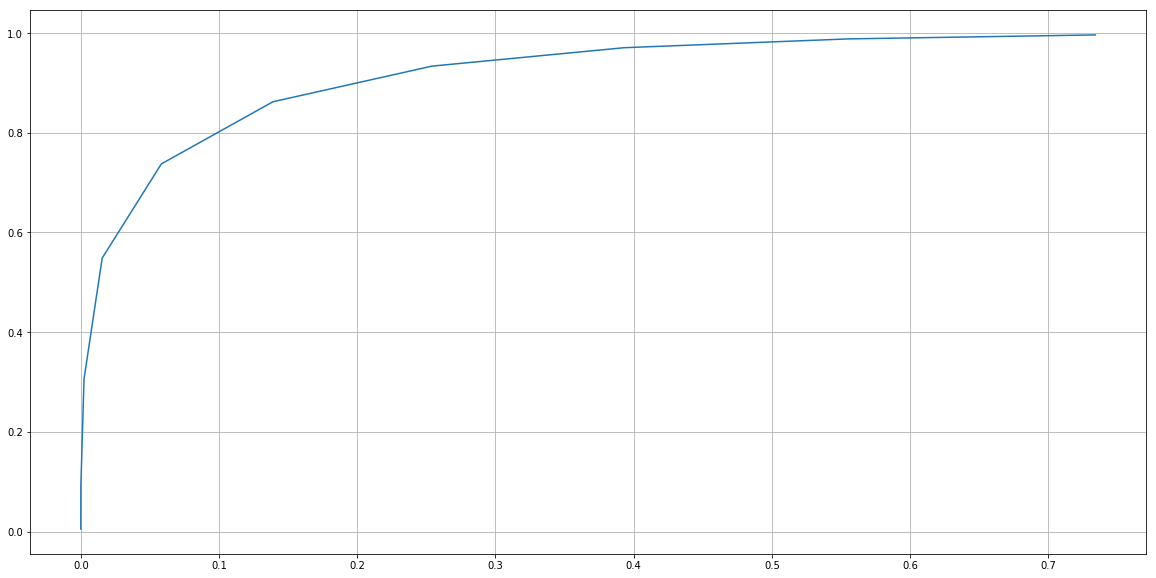

In [21]:
figure(figsize=(20,10))
plot(fars_p, vars_p)
grid()

In [22]:
f.close()

In [23]:
f = h5py.File('fi_acc.h5', 'r')

In [24]:
accs = f['acc_ls'].value

In [25]:
accs

array([0.39620434, 0.39620434, 0.39620434, 0.39620434, 0.39620434,
       0.39620434, 0.39620434, 0.39620434, 0.39620434, 0.39620434])

In [26]:
f.close()

In [27]:
f = h5py.File('face_pairs_dists.h5', 'r')

In [29]:
same_dists = f['same_dists'].value
diff_dists = f['diff_dists'].value

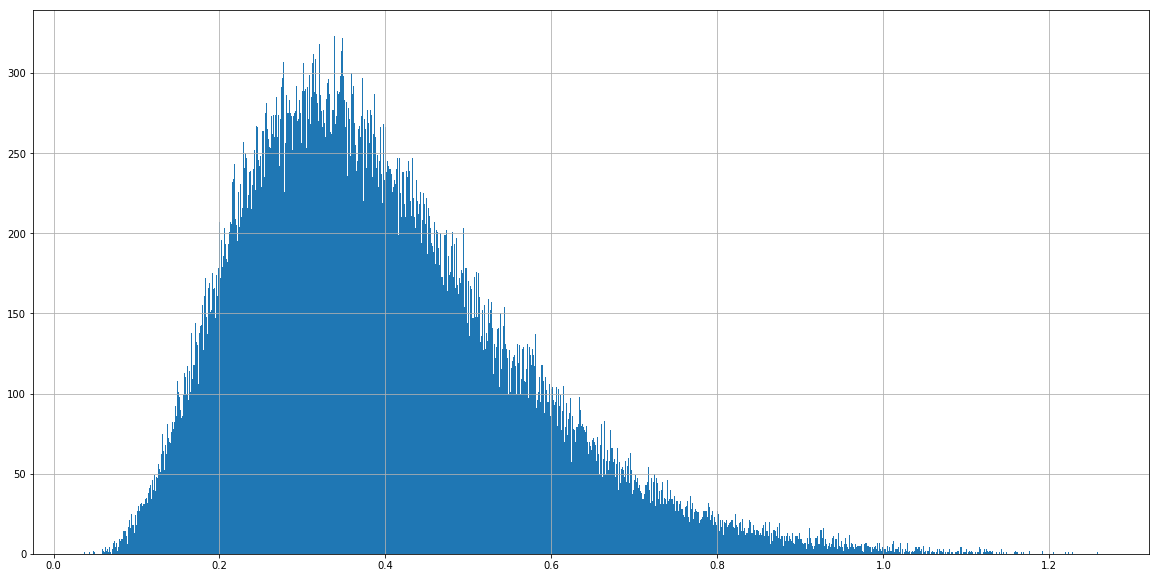

In [31]:
figure(figsize=(20,10))
hist(same_dists, bins=1000)
grid()

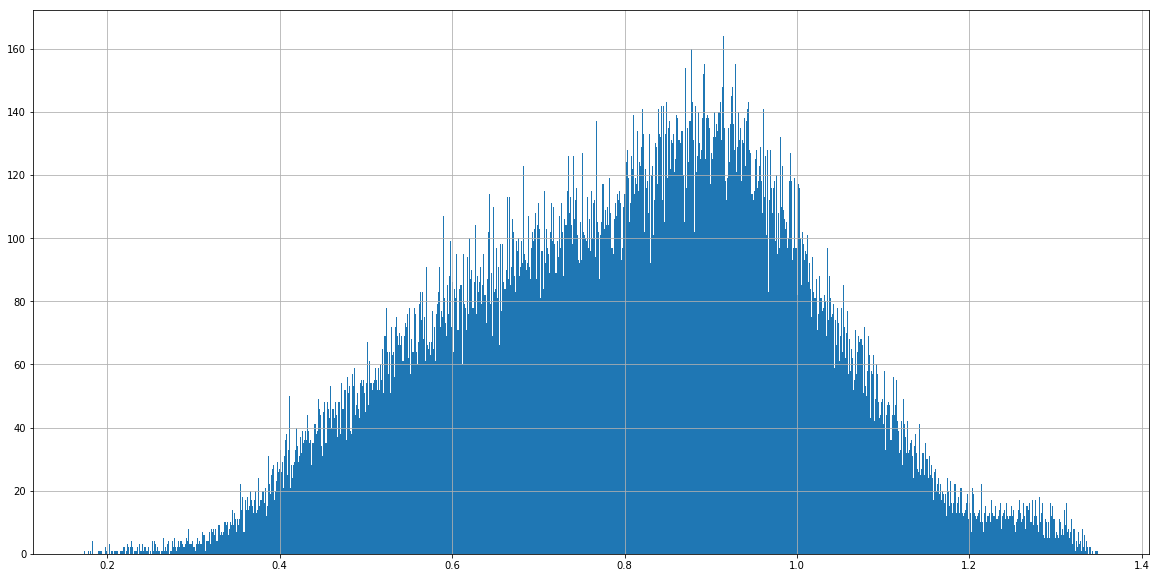

In [34]:
figure(figsize=(20,10))
hist(diff_dists, bins=1000)
grid()

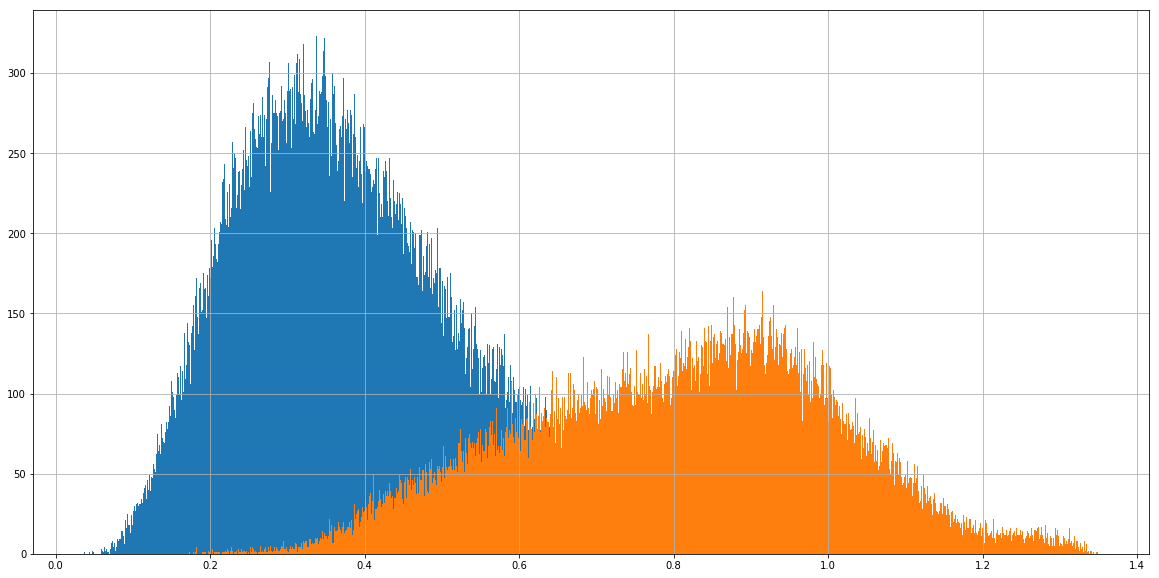

In [35]:
figure(figsize=(20,10))
hist(same_dists, bins=1000)
hist(diff_dists, bins=1000)
grid()

In [18]:
36+1+24+6

67

In [19]:
17+9+9

35

In [1]:
sample = {'a':10, 'b':20}

In [2]:
hasattr(sample, 'a')

False

In [6]:
isinstance(None, dict)

False

In [10]:
'a' in sample.keys()

True

In [11]:
sample.pop('a')

10

In [12]:
sample

{'b': 20}

In [4]:
from keras.layers import Conv2D, Conv2DTranspose, Reshape

In [46]:
input1 = Input(shape=(10,10,3))
input2 = Input(shape=(250,))
x1 = Conv2D(filters=10, kernel_size=3, strides=(2, 2), padding='same')(input1)
x1 = Flatten()(x1)
dense_layer = Dense(10)
output1 = dense_layer(x1)
output2 = dense_layer(input2)
model = Model([input1, input2], [output1, output2])
model.compile(optimizer='adam', loss='mse')

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 10, 3)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 5, 5, 10)     280         input_5[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 250)          0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
dense_3 (D

In [48]:
model.layers

In [49]:
model.inputs

[<tf.Tensor 'input_5:0' shape=(?, 10, 10, 3) dtype=float32>,
 <tf.Tensor 'input_6:0' shape=(?, 250) dtype=float32>]

In [50]:
model.outputs

[<tf.Tensor 'dense_3/BiasAdd:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'dense_3_1/BiasAdd:0' shape=(?, 10) dtype=float32>]

In [51]:
model.layers[0].name

'input_5'

In [52]:
sample = model.outputs[0]

In [53]:
sample.name.split('/')[0]

'dense_3'

In [54]:
model.layers[-2].name

'input_6'

In [55]:
model.layers[0]

In [56]:
isinstance(model.layers[0], keras.engine.input_layer.InputLayer)

True

In [57]:
layers = model.layers

In [58]:
layers.reverse()

In [59]:
layers

In [60]:
layers[0].weights

[<tf.Variable 'dense_3/kernel:0' shape=(250, 10) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32_ref>]

In [61]:
layer_1 = layers[0]

In [62]:
layer_1.name

'dense_3'

In [63]:
layer_1.input_shape

(None, 250)

In [64]:
layer_1.output_shape

(None, 10)

In [73]:
node_0 = layer_1._inbound_nodes[0]

In [84]:
node_0.input_shapes

[(None, 250)]

In [77]:
node_0.inbound_layers[0].name

'flatten_4'

In [78]:
node_1 = layer_1._inbound_nodes[1]
node_1.inbound_layers[0].name

'input_6'

In [69]:
W = layer_1.get_weights()

In [70]:
W[0].shape, W[1].shape

((250, 10), (10,))

In [85]:
layer_1.get_weights()[0].T.shape

(10, 250)

In [87]:
layer_1.activation

<function keras.activations.linear(x)>

In [196]:
cW = layers[2].get_weights()
cW[0].shape, cW[1].shape

((3, 3, 3, 10), (10,))

In [186]:
input2 = Input(shape=(10, ))
inv_layer_1 = Dense(layer_1.input_shape[1])
x_p = inv_layer_1(input2)
inv_layer_1.set_weights([layer_1.get_weights()[0].T, random.rand(250)])

In [187]:
x_p = Reshape((5,5,10))(x_p)

In [188]:
x_p.shape

TensorShape([Dimension(None), Dimension(5), Dimension(5), Dimension(10)])

In [189]:
inv_layer_2 = Conv2DTranspose(filters=3, kernel_size=3, strides=(2,2), padding='same')
x_p = inv_layer_2(x_p)

In [191]:
kW = inv_layer_2.get_weights()

In [195]:
kW[0].shape, kW[1].shape

((3, 3, 3, 10), (3,))

In [179]:
x_p.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(3)])

In [180]:
inv_model = Model(input2, x_p)

In [181]:
res1 = model.predict(np.random.rand(1,10,10,3))

In [182]:
res1.shape

(1, 10)

In [183]:
res1

array([[-0.17523639,  0.838447  ,  0.76211977,  0.9278917 , -0.06066033,
         0.35417974,  0.2786226 ,  1.0171303 ,  0.66685236,  0.35091972]],
      dtype=float32)

In [184]:
res2 = inv_model.predict(res1)

In [185]:
res2.shape

(1, 10, 10, 3)